In [16]:
!pip install pathway bokeh


In [19]:
import pandas as pd

# Load dataset
df = pd.read_csv('dataset.csv')  # Or upload manually in Colab

# Preview the data
df.head()
df.info()
df.describe(include='all')
df['SystemCodeNumber'].nunique()
  # Assuming this identifies unique lots


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18368 entries, 0 to 18367
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      18368 non-null  int64  
 1   SystemCodeNumber        18368 non-null  object 
 2   Capacity                18368 non-null  int64  
 3   Latitude                18368 non-null  float64
 4   Longitude               18368 non-null  float64
 5   Occupancy               18368 non-null  int64  
 6   VehicleType             18368 non-null  object 
 7   TrafficConditionNearby  18368 non-null  object 
 8   QueueLength             18368 non-null  int64  
 9   IsSpecialDay            18368 non-null  int64  
 10  LastUpdatedDate         18368 non-null  object 
 11  LastUpdatedTime         18368 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 1.7+ MB


14

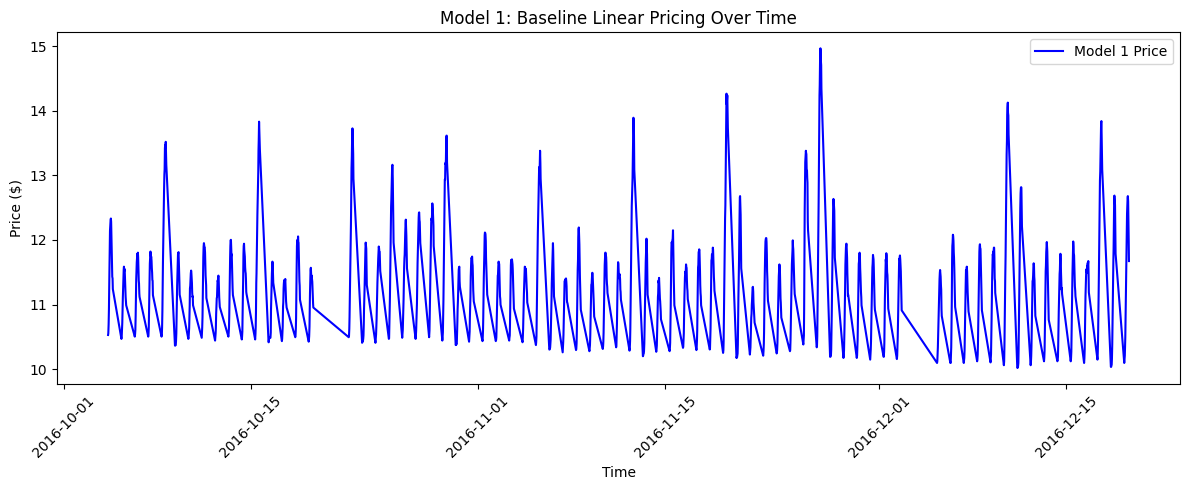

,SystemCodeNumber,timestamp,Occupancy,Capacity,occupancy_ratio,price_model_1
0,BHMBCCMKT01,2016-10-04 07:59:00,61,577,0.105719,10.528596
1,BHMBCCMKT01,2016-10-04 08:25:00,64,577,0.110919,10.554593
2,BHMBCCMKT01,2016-10-04 08:59:00,80,577,0.138648,10.693241
3,BHMBCCMKT01,2016-10-04 09:32:00,107,577,0.185442,10.927210
4,BHMBCCMKT01,2016-10-04 09:59:00,150,577,0.259965,11.299827


In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('dataset.csv')

# Combine date and time into a timestamp
df['timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'], dayfirst=True)

# Step 1: Preprocessing
# Calculate occupancy ratio
df['occupancy_ratio'] = df['Occupancy'] / df['Capacity']

# Step 2: Set Model 1 parameters
base_price = 10  # Starting price in dollars
alpha = 5        # Sensitivity factor

# Step 3: Apply Model 1 pricing formula
df['price_model_1'] = base_price + alpha * df['occupancy_ratio']

# Step 4: Clip price between $5 and $20
df['price_model_1'] = df['price_model_1'].clip(lower=5, upper=20)

# Optional: Sort by parking lot and timestamp
df.sort_values(by=['SystemCodeNumber', 'timestamp'], inplace=True)

# Step 5: Plot for one sample parking lot
sample_lot = df[df['SystemCodeNumber'] == df['SystemCodeNumber'].iloc[0]]

plt.figure(figsize=(12, 5))
plt.plot(sample_lot['timestamp'], sample_lot['price_model_1'], label='Model 1 Price', color='blue')
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.title("Model 1: Baseline Linear Pricing Over Time")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# View output
df[['SystemCodeNumber', 'timestamp', 'Occupancy', 'Capacity', 'occupancy_ratio', 'price_model_1']].head()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


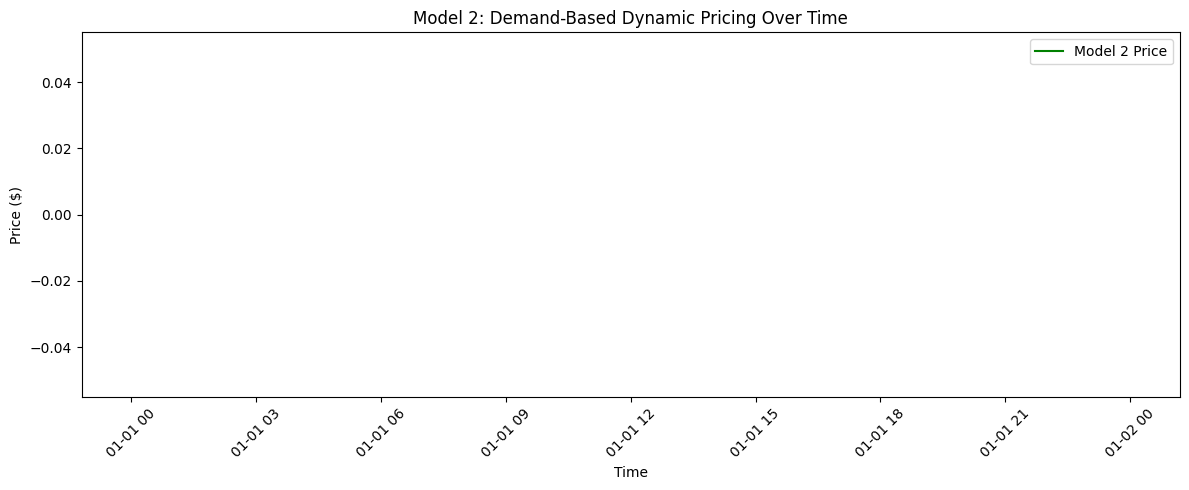

,SystemCodeNumber,timestamp,demand_raw,demand_normalized,price_model_2
0,BHMBCCMKT01,2016-10-04 07:59:00,NaN,NaN,NaN
1,BHMBCCMKT01,2016-10-04 08:25:00,NaN,NaN,NaN
2,BHMBCCMKT01,2016-10-04 08:59:00,NaN,NaN,NaN
3,BHMBCCMKT01,2016-10-04 09:32:00,NaN,NaN,NaN
4,BHMBCCMKT01,2016-10-04 09:59:00,NaN,NaN,NaN


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
df = pd.read_csv('dataset.csv')

# Step 1: Combine date and time into timestamp
df['timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'], dayfirst=True)

# Step 2: Preprocessing

# Map VehicleType to numeric weights
vehicle_weights = {'bike': 0.5, 'car': 1.0, 'truck': 1.5}
df['vehicle_type_weight'] = df['VehicleType'].map(vehicle_weights)

# Convert IsSpecialDay to integer (if needed)
df['IsSpecialDay'] = df['IsSpecialDay'].astype(int)

# Map traffic levels to numeric
traffic_map = {'Low': 0, 'Medium': 1, 'High': 2}
df['traffic_level'] = df['TrafficConditionNearby'].map(traffic_map)

# Calculate occupancy ratio
df['occupancy_ratio'] = df['Occupancy'] / df['Capacity']

# Step 3: Calculate Raw Demand Score

# Set feature weights
alpha = 0.4   # Occupancy
beta = 0.3    # Queue Length
gamma = -0.2  # Traffic (more traffic, less demand)
delta = 0.5   # Special day
epsilon = 0.6 # Vehicle type weight

# Compute raw demand
df['demand_raw'] = (
    alpha * df['occupancy_ratio'] +
    beta * df['QueueLength'] +
    gamma * df['traffic_level'] +
    delta * df['IsSpecialDay'] +
    epsilon * df['vehicle_type_weight']
)

# Step 4: Normalize Demand Score
scaler = MinMaxScaler()
df['demand_normalized'] = scaler.fit_transform(df[['demand_raw']])

# Step 5: Compute Price Using Demand
base_price = 10
lambda_ = 1  # Aggressiveness of pricing based on demand

df['price_model_2'] = base_price * (1 + lambda_ * df['demand_normalized'])

# Clip price between $5 and $20
df['price_model_2'] = df['price_model_2'].clip(lower=5, upper=20)

# Optional: Sort by parking lot and timestamp
df.sort_values(by=['SystemCodeNumber', 'timestamp'], inplace=True)

# Step 6: Plot Price Trend for a Sample Parking Lot
sample_lot = df[df['SystemCodeNumber'] == df['SystemCodeNumber'].iloc[0]]

plt.figure(figsize=(12, 5))
plt.plot(sample_lot['timestamp'], sample_lot['price_model_2'], label='Model 2 Price', color='green')
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.title("Model 2: Demand-Based Dynamic Pricing Over Time")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Step 7: View sample output
df[['SystemCodeNumber', 'timestamp', 'demand_raw', 'demand_normalized', 'price_model_2']].head()


In [27]:
df.isnull().sum()


,0
ID,0
SystemCodeNumber,0
Capacity,0
Latitude,0
Longitude,0
Occupancy,0
VehicleType,0
TrafficConditionNearby,0
QueueLength,0
IsSpecialDay,0


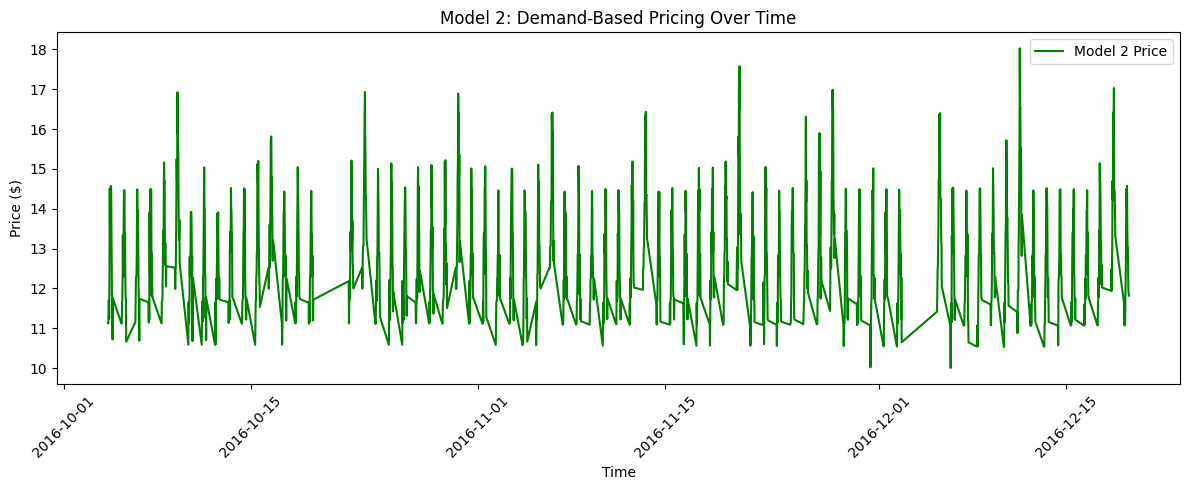

,SystemCodeNumber,timestamp,demand_raw,demand_normalized,price_model_2
6613,BHMNCPNST01,2016-10-06 16:30:00,1.529278,0.251710,12.517101
6791,BHMNCPNST01,2016-10-16 15:31:00,1.713608,0.284347,12.843466
16561,Others-CCCPS98,2016-11-20 11:27:00,3.384434,0.580174,15.801740
6640,BHMNCPNST01,2016-10-08 12:04:00,2.369897,0.400546,14.005455
4281,BHMMBMMBX01,2016-10-25 09:19:00,1.227656,0.198307,11.983066


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Step 1: Load the dataset
df = pd.read_csv('dataset.csv')

# Step 2: Create a timestamp from date and time
df['timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'], dayfirst=True)

# Step 3: Preprocessing

# VehicleType → vehicle_type_weight mapping
vehicle_weights = {
    'bike': 0.5,
    'car': 1.0,
    'truck': 1.5,
    'van': 1.2,
    'SUV': 1.3,
    'scooter': 0.4
}
df['vehicle_type_weight'] = df['VehicleType'].map(vehicle_weights)
df['vehicle_type_weight'] = df['vehicle_type_weight'].fillna(1.0)  # Default: car

# Convert IsSpecialDay to int
df['IsSpecialDay'] = df['IsSpecialDay'].astype(int)

# TrafficConditionNearby → numeric
traffic_map = {'Low': 0, 'Medium': 1, 'High': 2}
df['traffic_level'] = df['TrafficConditionNearby'].map(traffic_map)
df['traffic_level'] = df['traffic_level'].fillna(1)  # Default: Medium

# Handle any missing queue length
df['QueueLength'] = df['QueueLength'].fillna(0)

# Calculate occupancy ratio
df['occupancy_ratio'] = df['Occupancy'] / df['Capacity']

# Step 4: Compute demand score
alpha = 0.4
beta = 0.3
gamma = -0.2
delta = 0.5
epsilon = 0.6

df['demand_raw'] = (
    alpha * df['occupancy_ratio'] +
    beta * df['QueueLength'] +
    gamma * df['traffic_level'] +
    delta * df['IsSpecialDay'] +
    epsilon * df['vehicle_type_weight']
)

# Step 5: Normalize demand
scaler = MinMaxScaler()
df['demand_normalized'] = scaler.fit_transform(df[['demand_raw']])

# Step 6: Calculate price
base_price = 10
lambda_ = 1
df['price_model_2'] = base_price * (1 + lambda_ * df['demand_normalized'])
df['price_model_2'] = df['price_model_2'].clip(lower=5, upper=20)

# Optional: Sort
df.sort_values(by=['SystemCodeNumber', 'timestamp'], inplace=True)

# Step 7: Plot price for one sample lot
sample_lot = df[df['SystemCodeNumber'] == df['SystemCodeNumber'].iloc[0]]

plt.figure(figsize=(12, 5))
plt.plot(sample_lot['timestamp'], sample_lot['price_model_2'], label='Model 2 Price', color='green')
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.title("Model 2: Demand-Based Pricing Over Time")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Step 8: Final output check
df[['SystemCodeNumber', 'timestamp', 'demand_raw', 'demand_normalized', 'price_model_2']].sample(5)


In [35]:
# Install Pathway
!pip install pathway --quiet

import pathway as pw

# Step 1: Define the correct schema matching your dataset columns
class ParkingSchema(pw.Schema):
    SystemCodeNumber: str
    Capacity: int
    Occupancy: int
    QueueLength: int
    TrafficConditionNearby: str
    IsSpecialDay: int
    VehicleType: str
    LastUpdatedDate: str
    LastUpdatedTime: str

# Step 2: Read the dataset in static mode (to run instantly)
t = pw.io.csv.read(
    "dataset.csv",     # Make sure this is uploaded in the same directory
    schema=ParkingSchema,
    mode="static"      # Static mode = full batch processing
)

# Step 3: Define your Model 2 pricing logic as a UDF
@pw.udf
def compute_price(SystemCodeNumber, Capacity, Occupancy, QueueLength,
                  TrafficConditionNearby, IsSpecialDay, VehicleType):
    # Weight maps
    vehicle_weights = {
        'bike': 0.5, 'car': 1.0, 'truck': 1.5,
        'van': 1.2, 'SUV': 1.3, 'scooter': 0.4
    }
    traffic_map = {'Low': 0, 'Medium': 1, 'High': 2}

    # Safe calculations
    occupancy_ratio = Occupancy / Capacity if Capacity != 0 else 0
    queue = QueueLength or 0
    traffic_level = traffic_map.get(TrafficConditionNearby, 1)
    vehicle_weight = vehicle_weights.get(VehicleType, 1.0)
    special_day = int(IsSpecialDay)

    # Demand function
    alpha, beta, gamma, delta, epsilon = 0.4, 0.3, -0.2, 0.5, 0.6
    demand = (
        alpha * occupancy_ratio +
        beta * queue +
        gamma * traffic_level +
        delta * special_day +
        epsilon * vehicle_weight
    )

    # Normalize demand: assume range ~[-5, +5]
    demand_norm = max(min((demand + 5) / 10, 1.0), 0.0)

    # Compute price
    base_price = 10
    lamb = 1
    price = base_price * (1 + lamb * demand_norm)

    # Clamp price between $5 and $20
    return float(round(min(max(price, 5), 20), 2))

# Step 4: Apply the pricing function to the data
pricing = t.with_columns(
    Price=compute_price(
        t.SystemCodeNumber, t.Capacity, t.Occupancy, t.QueueLength,
        t.TrafficConditionNearby, t.IsSpecialDay, t.VehicleType
    )
)

# Step 5: Print results in console
pricing.show()

# Step 6: Run the pipeline
pw.run()


Output()

KeyboardInterrupt: 